# Question A4

In this section, we will understand the utility of such a neural network in real world scenarios.

#### Please use the real record data named ‘record.wav’  as a test sample. Preprocess the data using the provided preprocessing script (data_preprocess.ipynb) and prepare the dataset.
Do a model prediction on the sample test dataset and obtain the predicted label using a threshold of 0.5. The model used is the optimized pretrained model using the selected optimal batch size and optimal number of neurons.
Find the most important features on the model prediction for the test sample using SHAP. Plot the local feature importance with a force plot and explain your observations.  (Refer to the documentation and these three useful references:
https://christophm.github.io/interpretable-ml-book/shap.html#examples-5,
https://towardsdatascience.com/deep-learning-model-interpretation-using-shap-a21786e91d16,  
https://medium.com/mlearning-ai/shap-force-plots-for-classification-d30be430e195)



1. Firstly, we import relevant libraries.

In [14]:
import tqdm
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from scipy.io import wavfile as wav

from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
from common_utils import set_seed

# setting seed
set_seed()

To reduce repeated code, place your
network (MLP defined in QA1)
torch datasets (CustomDataset defined in QA1)
loss function (loss_fn defined in QA1)
in a separate file called common_utils.py

Import them into this file. You will not be repenalised for any error in QA1 here as the code in QA1 will not be remarked.

The following code cell will not be marked.


In [15]:
# YOUR CODE HERE
from common_utils import CustomDataset, loss_fn, preprocess_dataset, EarlyStopper

2. Install and import shap

In [16]:
# YOUR CODE HERE
# !pip install shap

import shap

3. Read the csv data preprocessed from 'record.wav', using variable name 'df', and fill the size of 'df' in 'size_row' and 'size_column'.

In [17]:
df = pd.read_csv("new_record.csv")
size_row = df.shape[0]
size_column = df.shape[1]
# YOUR CODE HERE

print(f"row size = {size_row}")
print(f"col size = {size_column}")

row size = 1
col size = 78


 4.  Preprocess to obtain the test data, save the test data as numpy array.

In [18]:

def preprocess(X_train, df):
    """preprocess your dataset to obtain your test dataset, remember to remove the 'filename' as Q1
    """

    # YOUR CODE HERE
    df_dropped = df.drop("filename", axis=1)
    X_train_scaled, X_test_scaled_eg = preprocess_dataset(X_train, df_dropped)

    return X_test_scaled_eg





#Using the whole simplified.csv as train data
label_encoder = preprocessing.LabelEncoder()

df_simplified = pd.read_csv('simplified.csv')
df_simplified['label'] = df_simplified['filename'].str.split('_').str[-2]
df_simplified['label'] = label_encoder.fit_transform(df_simplified['label'])  #changing the labels from neg/pos to 1/0

y = df_simplified['label'].to_numpy()
X = df_simplified.drop(["filename","label"], axis=1)

#70:30 split, similar to A3
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 1)
X_train_scaled, X_test_scaled = preprocess_dataset(X_train, X_test)

#getting our single preprocessed test sample
X_test_scaled_eg = preprocess(X_train, df)

5. Do a model prediction on the sample test dataset and obtain the predicted label using a threshold of 0.5. The model used is the optimized pretrained model using the selected optimal batch size and optimal number of neurons. Note: Please define the variable of your final predicted label as 'pred_label'.

In [19]:
# YOUR CODE HERE

#implementing train loop
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    train_loss, correct = 0, 0
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        y_long = y.type(torch.LongTensor)
        loss = loss_fn(pred, y_long)

        # Backpropagation
        optimizer.zero_grad()  #initialize gradient calculations
        loss.backward()  #compute gradients
        optimizer.step()  #take one step of SGD

        train_loss += loss.item()
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    train_loss /= size
    correct /= size
    return train_loss, correct


def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            y_long = y.type(torch.LongTensor)
            test_loss += loss_fn(pred, y_long).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= size
    correct /= size

    return test_loss, correct


#MLP model
class MLP(nn.Module):
    def __init__(self, no_features, no_hidden, no_labels):
        super().__init__()
        self.mlp_stack = nn.Sequential(
            # YOUR CODE HERE
            nn.Linear(no_features, no_hidden),  #first hidden layer
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(no_hidden, 128),  #second hidden layer
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(128, 128),  #third hidden layer
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(128, no_labels),  #output layer
            nn.Sigmoid()
        )

    # YOUR CODE HERE
    def forward(self, x):
        logits = self.mlp_stack(x)
        return logits


no_features = 77
no_labels = 2
no_hidden = 256 #optimal number of neurons for the first hidden layer
batch_size = 1024 #optimal batch size
no_epochs = 100
lr = 0.001


model = MLP(no_features, no_hidden, no_labels)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
loss_fn = nn.CrossEntropyLoss() #can be used for binary classification too

#initilising dataloaders
train_data = CustomDataset(X_train_scaled, y_train)
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

test_data = CustomDataset(X_test_scaled, y_test)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)


#initialising early stopper 
early_stopper = EarlyStopper(min_delta = 0.00005) #min_delta = 0.00005
early_stopper_bool = False



#training the model
for epoch in range(no_epochs):
    train_loss, train_acc = train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loss, test_accuracy = test_loop(test_dataloader, model, loss_fn)

    if epoch%10 == 9:
        print(f"Epoch {epoch+1} done!")

    early_stopper_bool = early_stopper.early_stop(test_loss)
    if early_stopper_bool:
        print(f"Early stopped at {epoch+1}!")
        break


print("---------------------------")
x_new = torch.tensor(X_test_scaled_eg, dtype=torch.float)
output = model(x_new)
print(output)


pred_label = output.argmax(1).item()
print(f"\nThe predicted label is {pred_label}")

Epoch 10 done!
Epoch 20 done!
Epoch 30 done!
Epoch 40 done!
Epoch 50 done!
Epoch 60 done!
Epoch 70 done!
Epoch 80 done!
Epoch 90 done!
Epoch 100 done!
---------------------------
tensor([[8.1802e-08, 1.0000e+00]], grad_fn=<SigmoidBackward0>)

The predicted label is 1


6. Find the most important features on the model prediction for your test sample using SHAP. Create an instance of the DeepSHAP which is called DeepExplainer using traianing dataset: https://shap-lrjball.readthedocs.io/en/latest/generated/shap.DeepExplainer.html.

Plot the local feature importance with a force plot and explain your observations.  (Refer to the documentation and these three useful references:
https://christophm.github.io/interpretable-ml-book/shap.html#examples-5,
https://towardsdatascience.com/deep-learning-model-interpretation-using-shap-a21786e91d16,  
https://medium.com/mlearning-ai/shap-force-plots-for-classification-d30be430e195)


In [20]:
'''
Fit the explainer on a subset of the data (you can try all but then gets slower)
Return approximate SHAP values for the model applied to the data given by X.
Plot the local feature importance with a force plot and explain your observations.
'''
# YOUR CODE HERE

df_test=df.drop(columns=['filename'], axis=1)


X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float)
X_test_tensor = torch.tensor(X_test_scaled_eg, dtype=torch.float)

explainer = shap.DeepExplainer(model, data = X_train_tensor)


#getting SHAP values
shap_values = explainer.shap_values(X_test_tensor)


#converting the test sample from a tensor to a np.array
X_test_sample_np = X_test_tensor[0].detach().numpy()

#plotting the force plot
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0], X_test_sample_np, feature_names=list(df_test.columns))


Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


In [21]:
answer = "From the forceplot, the features that were important to making the prediction for this observation are shown in\
red and blue, with red representing features that pushed the model score higher, and blue representing features that pushed\
the score lower. The feature that was most importance can be seen by the size of the bar, and that was 'spec_bw_var'."

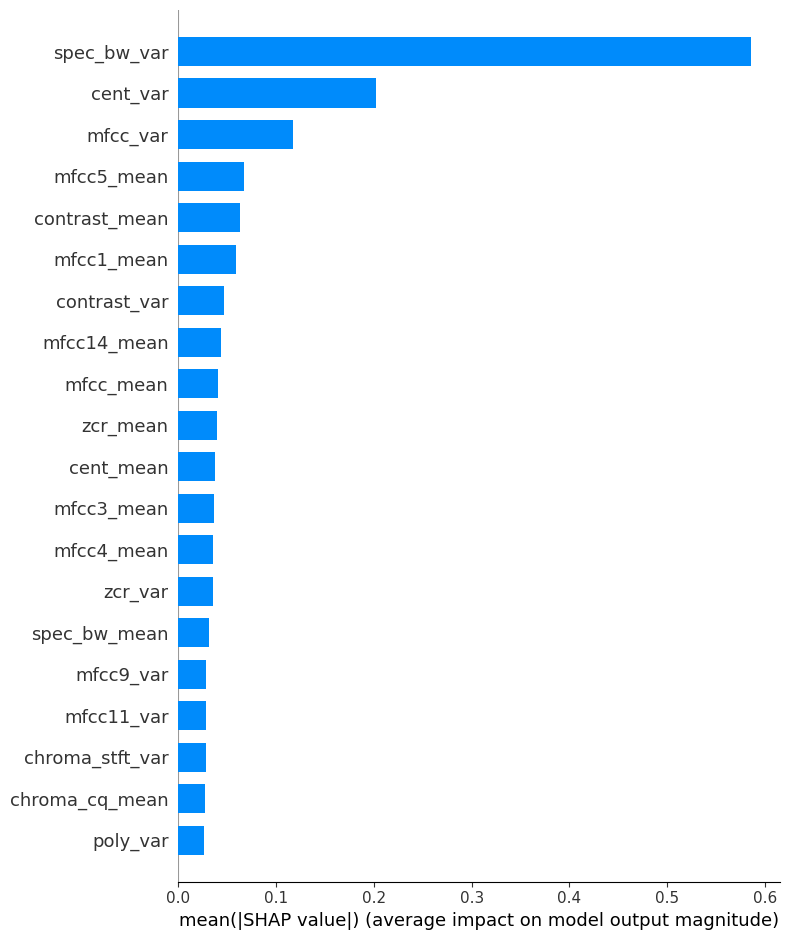

In [22]:
shap.summary_plot(shap_values[0], plot_type='bar', feature_names=list(df_test.columns))